# Health Insurance Lead Prediction

Your Client FinMan is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

#### Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

#### Now the company needs your help in building a model to predict whether the person will be interested in their proposed Health plan/policy given the information about:

- Demographics (city, age, region etc.)
- Information regarding holding policies of the customer
- Recommended Policy Information


**Data Dictionary**

- Variable	Definition
- ID	Unique Identifier for a row
- City_Code	Code for the City of the customers
- Region_Code	Code for the Region of the customers
- Accomodation_Type	Customer Owns or Rents the house
- Reco_Insurance_Type	Joint or Individual type for the recommended insurance  
- Upper_Age	Maximum age of the customer 
- Lower _Age	Minimum age of the customer
- Is_Spouse	If the customers are married to each other (in case of joint insurance) 
- Health_Indicator Encoded values for health of the customer
- Holding_Policy_Duration	Duration (in years) of holding policy (a policy that customer has already subscribed to with the company)
- Holding_Policy_Type Type of holding policy
- Reco_Policy_Cat	Encoded value for recommended health insurance
- Reco_Policy_Premium	Annual Premium (INR) for the recommended health insurance
- Response (Target)	0 : Customer did not show interest in the recommended policy, 1 : Customer showed interest in the recommended policy

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import seaborn as sns 

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('Train1.csv')
test = pd.read_csv('Test1.csv')

In [3]:
train.shape, test.shape

((50882, 14), (21805, 13))

In [4]:
data = pd.concat([train, test])
data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0.0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0.0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1.0
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0.0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0.0


In [5]:
data.isnull().mean()

ID                         0.000000
City_Code                  0.000000
Region_Code                0.000000
Accomodation_Type          0.000000
Reco_Insurance_Type        0.000000
Upper_Age                  0.000000
Lower_Age                  0.000000
Is_Spouse                  0.000000
Health Indicator           0.230000
Holding_Policy_Duration    0.396962
Holding_Policy_Type        0.396962
Reco_Policy_Cat            0.000000
Reco_Policy_Premium        0.000000
Response                   0.299985
dtype: float64

In [6]:
data.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                   float64
dtype: object

In [201]:
data['Response'].value_counts(normalize=True)

0.0    0.760053
1.0    0.239947
Name: Response, dtype: float64

## Univariate Analysis (Categorical) 

In [96]:
def UVA_Cat(data, column, rot=0):
    """
    Function to plot countplot and pie chart for categorical variables.
    
    """
    for j, i in enumerate(column):
        
        #plt.subplot(2,1, j+1)
        
        # Setting the figure size
        plt.figure(figsize=(10,3), dpi=100)
    
    
        # ploting the barplot
        plt.subplot(1,2,1)
        g=sns.countplot(x=i, data= data)
        plt.title('Barplot for {}'.format(i), fontsize=14)
        plt.xticks(rotation=rot)
        #plt.rc('xtick',labelsize=8)
        plt.tight_layout()
        
        #ploting the pie chart 
        plt.subplot(1,2,2)
        plt.axis('equal')
        plt.pie(x= data[i].value_counts(), labels= data[i].value_counts().index, autopct='%0.1f%%', shadow=True)
        plt.title('Pie chart for {}'.format(i), fontsize=14)
        plt.tight_layout()
        plt.show()

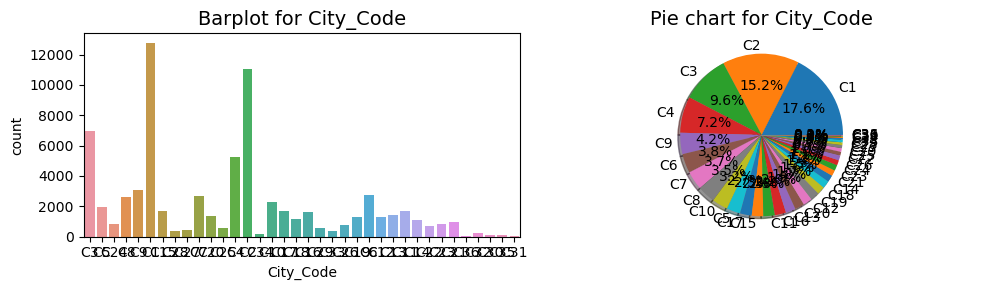

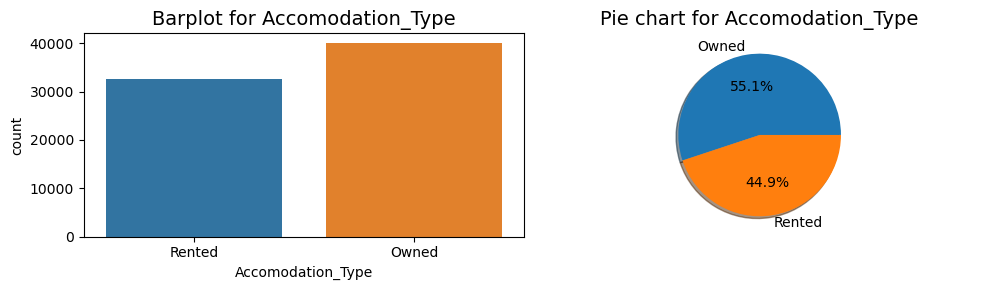

In [97]:
UVA_Cat(data, ['City_Code','Accomodation_Type'])

In [98]:
data.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

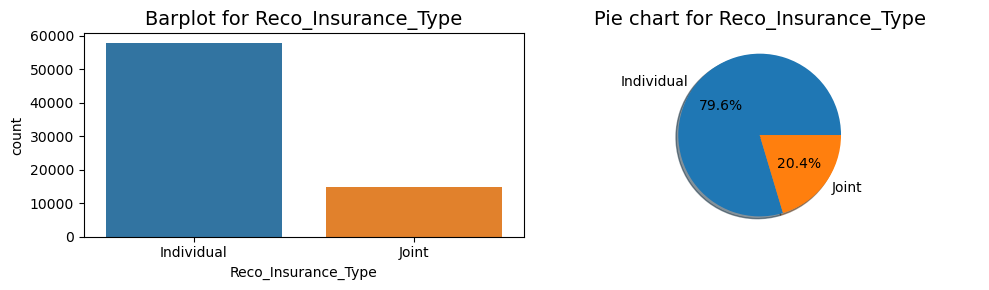

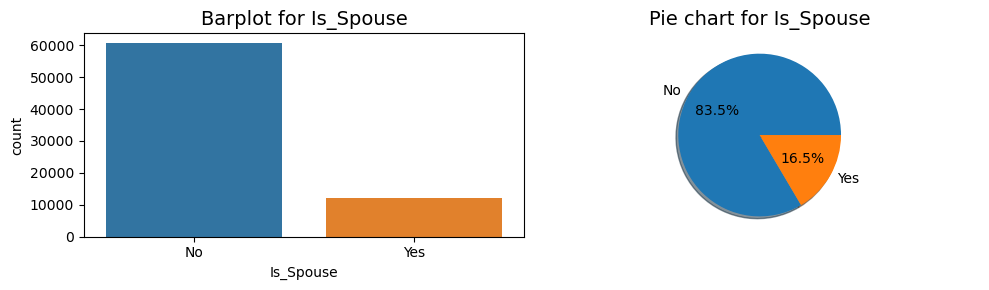

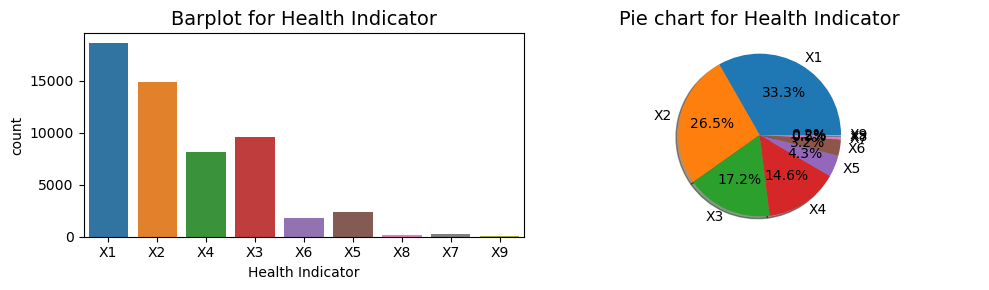

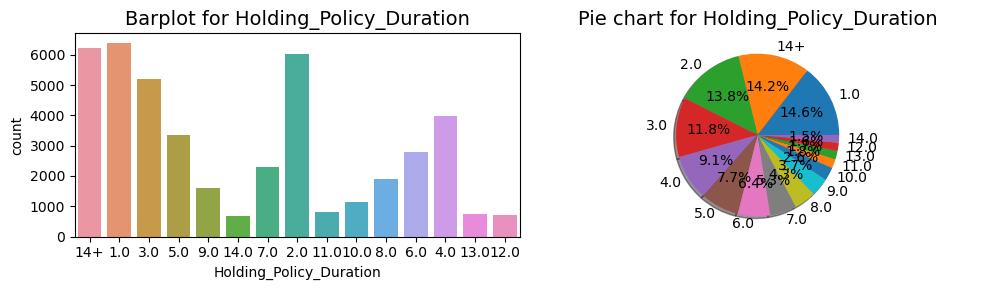

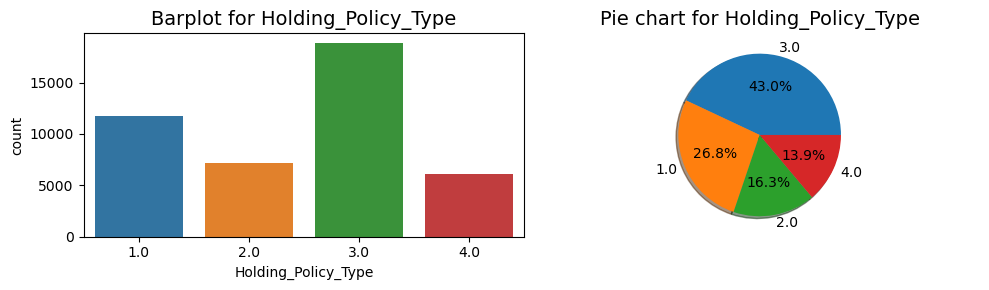

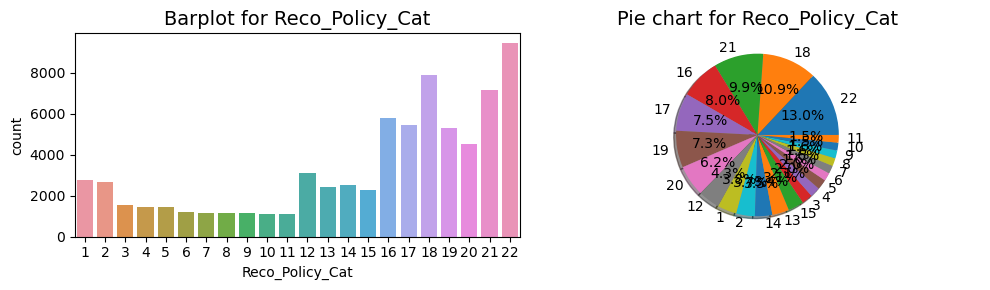

In [99]:
UVA_Cat(data, ['Reco_Insurance_Type', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', ])

# Univariate (continous)

In [100]:
def UVA_Cont(data1, var, include_outlier=True):
    
    """
    Function for univariate analysis of continiuous variables.
    Plots Kdeplot and Boxplot for given continiuous variable. 
    It also takes in argument of wheater to include the outliers while ploting the graphs or not.
    By default it plots graphs with outliers.
    """
    data = data1.copy()
    
    if include_outlier == False:
        
        #Calculating quantiles 
        quant25 = data[var].quantile(0.25)
        quant75 = data[var].quantile(0.75)
        IQR     = quant75 - quant25
        
        # Fitlering data(removing outliers)
        data[var] = data[var][(data[var] < (quant75+ 1.5*IQR)) & (data[var] > (quant25- 1.5*IQR))]
    
    
    #Calculating descriptive statistics 
    mini    = data[var].min()
    maxi    = data[var].max()
    rang    = mini - maxi
    mean    = data[var].mean()
    med     = data[var].median()
    std_    = data[var].std()
    skew    = data[var].skew()
    kurt    = data[var].kurtosis()
    quant25 = data[var].quantile(0.25)
    quant75 = data[var].quantile(0.75)
    IQR     = quant75 - quant25
    whis_low = quant25 - (1.5*IQR)
    whis_high = quant75 + (1.5*IQR)
    
    #Calculating the points of standerd daviation 
    points = mean-std_, mean+std_
    
    # Calculating Number of Outliers
    outlier_high = len(data[var][data[var]>whis_high])
    outlier_low = len(data[var][data[var]<whis_low])
    
    
    #Ploting kdeplot for continious variable 
    plt.figure(figsize=(18,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    
    sns.kdeplot(data[var],shade=True)
    sns.lineplot(points,[0,0],color='black',label='std_dev')
    sns.scatterplot([mini,maxi],[0,0],color='red',label='min\max')
    sns.scatterplot(mean,[0],color='blue',label='mean')
    sns.scatterplot(med,[0],color='green',label='median')
    plt.xlabel("{}".format(var),fontsize=(14))
    plt.ylabel('density',fontsize=(14))
    plt.tight_layout()
    plt.title('\tstd_dev= {}; \tkurtosis= {}; \tskew= {};\n\tmean= {}; \tmedian= {}; \trange = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                               round(kurt,2),
                                                                                                 round(skew,2),
                                                                                                 round(mean,2),
                                                                                                 round(med,2),
                                                                                                 (round(mini,2),round(maxi,2),round(rang,2))),fontsize=14)
    plt.tight_layout()
        
    #Ploting boxplot for continious variable
    ax1 = plt.subplot(gs[1])
    sns.boxplot(data[var], orient="v")
    plt.title('\tIQR = {};\tOutlier (low/high) = {};\n\t2nd,3rd  quartile = {};'.format(round(IQR,2),
                                                                                            (outlier_low,outlier_high),
                                                                                            (round(quant25,2),round(quant75,2))), fontsize=14)
    plt.ylabel("{}".format(var),fontsize=(14))
    plt.tight_layout()

In [101]:
data.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

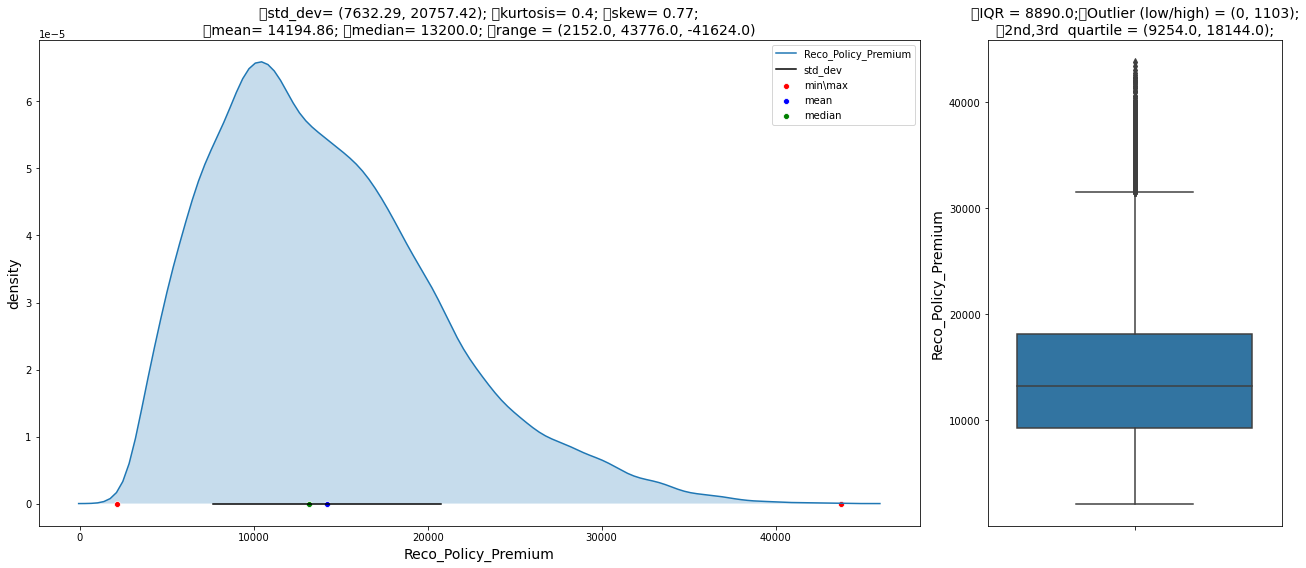

In [102]:
UVA_Cont(data, 'Reco_Policy_Premium')

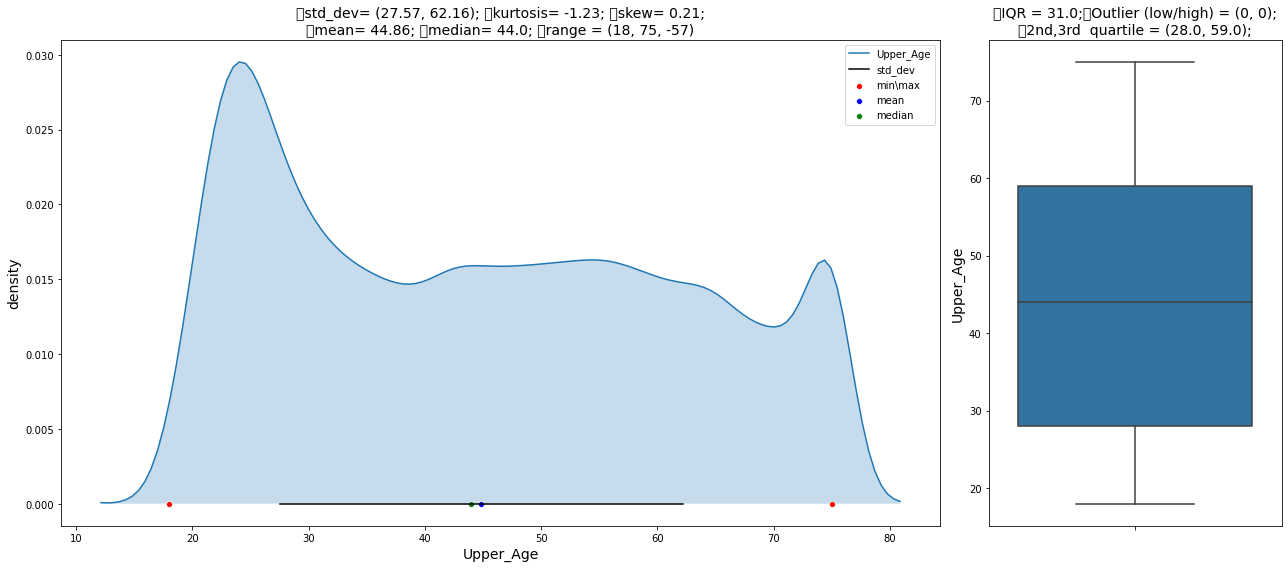

In [103]:
UVA_Cont(data, 'Upper_Age')

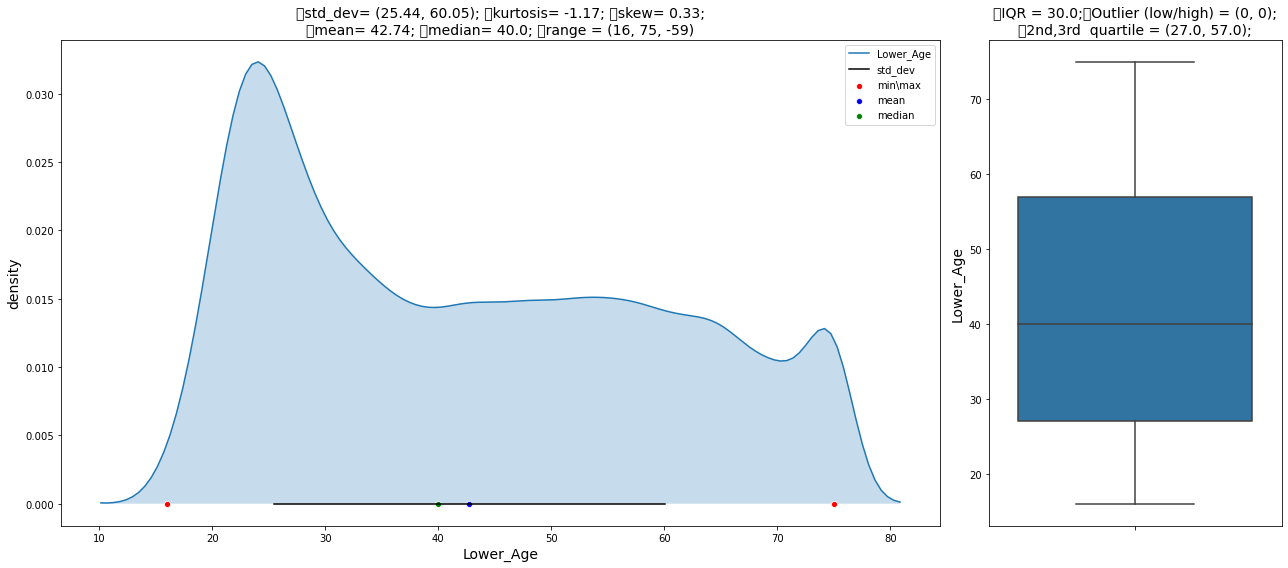

In [104]:
UVA_Cont(data, 'Lower_Age')

## Bi-variate Analysis (Continous-categorical)

In [105]:
def BVA_Cont_Cat(data, cont, cat, stat_test=False):
    
    """
    """
    
    # Perform a t-test z-test if condition is true
    if stat_test == True:
        
        # giving category as 1
        category = 1
        
        # creating 2 samples
        x1 = data[cont][data[cat]==category][:]
        x2 = data[cont][~(data[cat]==category)][:]
        
        # calculating descriptive statistics 
        n1, n2 = x1.shape[0], x2.shape[0]
        m1, m2 = x1.mean(), x2.mean()
        std1, std2 = x1.std(), x2.std()
        
        # calculating p-values
        t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
        z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)
    
    #Setting the figure size
    plt.figure(figsize=(18,7))
    
    #Ploting barplot between cont. var and target
    plt.subplot(1,2,1)
    g = sns.barplot(x=cat, y=cont, data=data, ci=False, palette='Set2')
    
    if stat_test == True:
        plt.title('Barplot for {} and Response\n\tt-test p-value = {} \tz-test p-value = {}'.format(cont,t_p_val, z_p_val), fontsize=16)
    
    else:
        plt.title('Barplot for {} and Response'.format(cont), fontsize=16)
    
    plt.xlabel('{}'.format(cat),fontsize=12)
    plt.ylabel('{}'.format(cont),fontsize=12)
    for i in g.patches:
            g.annotate(s='{:.0f}'.format(i.get_height()), xy=(i.get_x()+0.3, i.get_height()+1))
    
    #Ploting stripplot between cont var and target 
    plt.subplot(1,2,2)
    sns.stripplot(x=cat, y=cont, data=data, palette='Set2')
    plt.title('Stripplot for {} and Response'.format(cont), fontsize=16)
    plt.xlabel('{}'.format(cat),fontsize=12)
    plt.ylabel('{}'.format(cont),fontsize=12)
    plt.tight_layout()

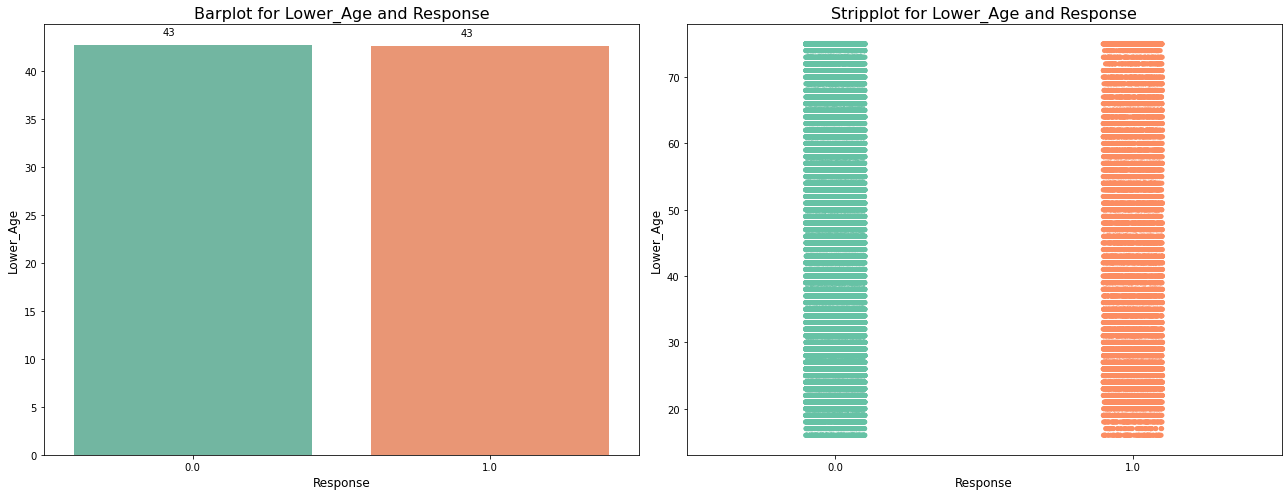

In [106]:
BVA_Cont_Cat(data, 'Lower_Age', 'Response')

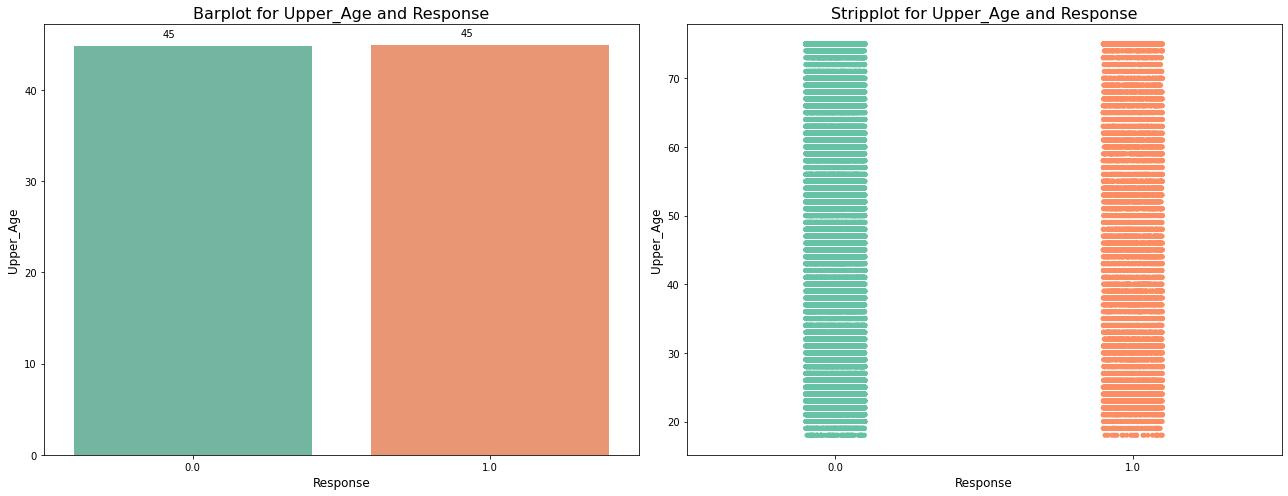

In [107]:
BVA_Cont_Cat(data, 'Upper_Age', 'Response')

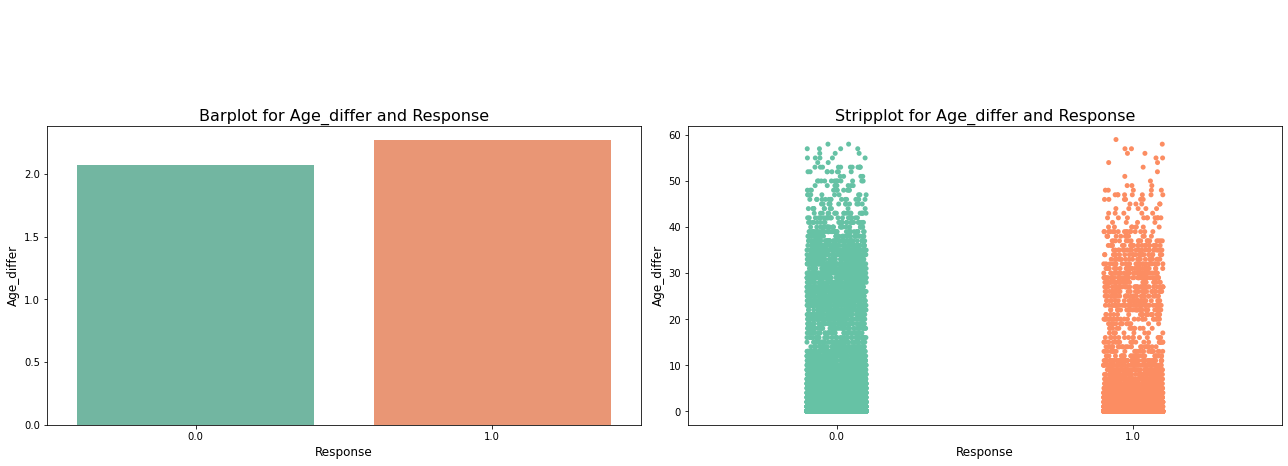

In [109]:
BVA_Cont_Cat(data, 'Age_differ', 'Response')

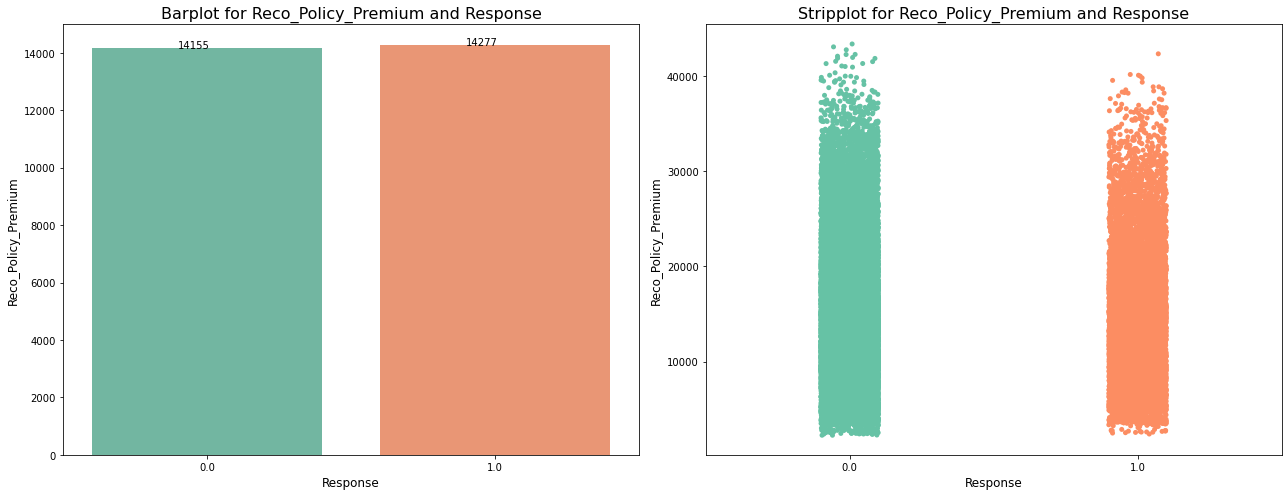

In [110]:
BVA_Cont_Cat(data, 'Reco_Policy_Premium', 'Response')

# Bi-Variate (Categorical-Categorical)

In [111]:
def BVA_cat_cat(data, tar, cat):
    '''
    take data and two categorical variables,
    calculates the chi2 significance between the two variables 
    and prints the result with countplot & CrossTab
    '''
    #isolating the variables
    data = data[[cat,tar]][:]

    #forming a crosstab
    table = pd.crosstab(data[tar],data[cat],)
    f_obs = np.array([table.iloc[0][:].values,
                    table.iloc[1][:].values])

    #performing chi2 test
    from scipy.stats import chi2_contingency
    chi, p, dof, expected = chi2_contingency(f_obs)
  
    #checking whether results are significant
    if p<0.05:
        sig = True
    else:
        sig = False
    
    #plotting grouped plot
    g = sns.countplot(x=cat, hue=tar, data=data)
    plt.title("p-value = {}\n difference significant? = {}\n".format(round(p,8),sig))
    for p in g.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        g.text(x+width/2, 
            y+height, 
            '{:.0f}'.format(height), 
            horizontalalignment='center')

    
    
    #plotting percent stacked bar plot
    g = (data.groupby(cat)[tar].value_counts(normalize=True)*100).unstack().plot(kind='bar', stacked='True')
    plt.ylabel('Percentage')
    for p in g.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        g.text(x+width/2, 
            y+height/2, 
            '{:.0f} %'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

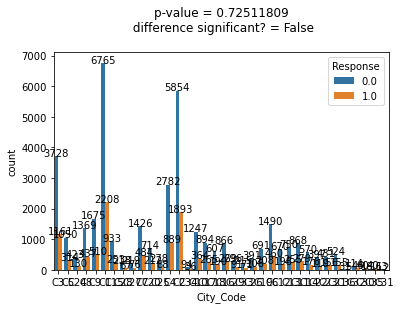

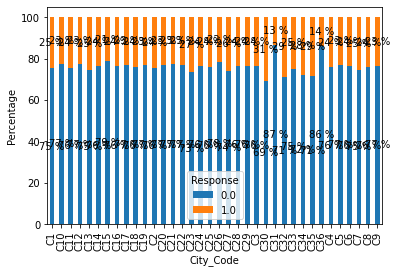

In [113]:
BVA_cat_cat(data, 'Response','City_Code')

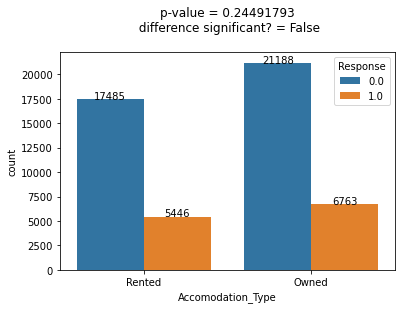

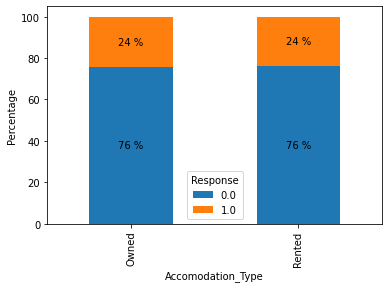

In [114]:
BVA_cat_cat(data, 'Response', 'Accomodation_Type')

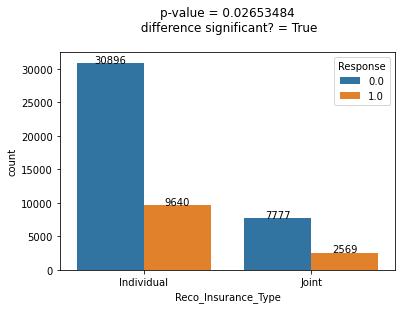

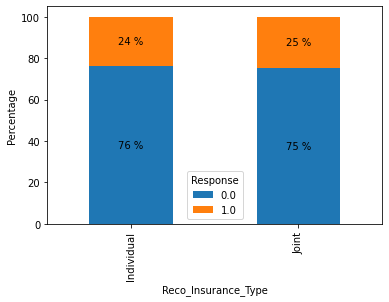

In [115]:
BVA_cat_cat(data, 'Response','Reco_Insurance_Type')

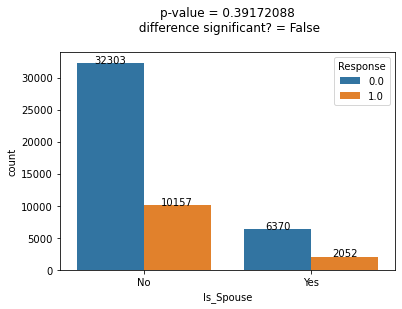

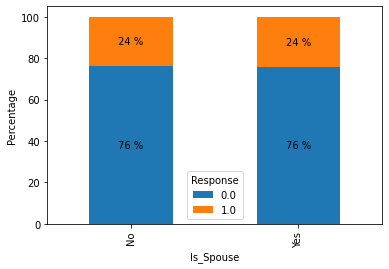

In [116]:
BVA_cat_cat(data, 'Response','Is_Spouse')

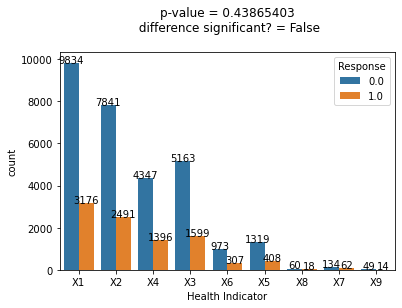

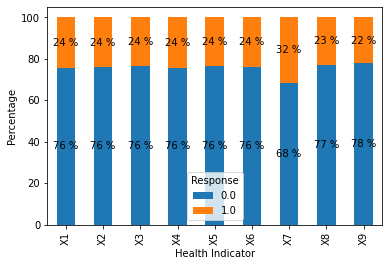

In [117]:
BVA_cat_cat(data, 'Response','Health Indicator')

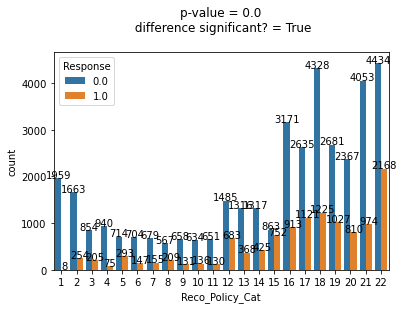

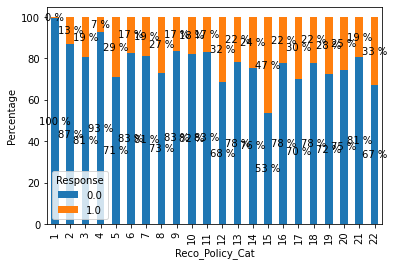

In [118]:
BVA_cat_cat(data, 'Response','Reco_Policy_Cat')

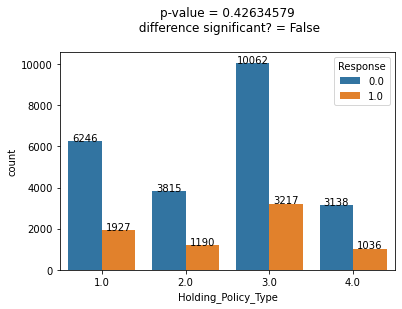

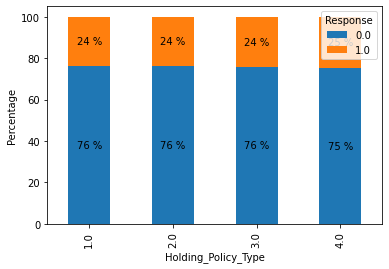

In [119]:
BVA_cat_cat(data, 'Response','Holding_Policy_Type')

In [7]:
data.isnull().mean()

ID                         0.000000
City_Code                  0.000000
Region_Code                0.000000
Accomodation_Type          0.000000
Reco_Insurance_Type        0.000000
Upper_Age                  0.000000
Lower_Age                  0.000000
Is_Spouse                  0.000000
Health Indicator           0.230000
Holding_Policy_Duration    0.396962
Holding_Policy_Type        0.396962
Reco_Policy_Cat            0.000000
Reco_Policy_Premium        0.000000
Response                   0.299985
dtype: float64

# Data Pre Processing

In [9]:
data['Health Indicator'].fillna('Not_Known', inplace=True)
data['Holding_Policy_Duration'].fillna(0,inplace=True)
data['Holding_Policy_Type'].fillna('No_Prior_Policy', inplace=True)

In [204]:
data.loc[data['Holding_Policy_Type']=='No_Prior_Policy', 'Customer_Type'] = 0
data['Customer_Type'].fillna(1, inplace=True)

## Preprocessing 

In [127]:
data.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type         object
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                   float64
Age_differ                   int64
dtype: object

In [128]:
df = pd.get_dummies(data, columns=['Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse',
                              'Health Indicator','Holding_Policy_Type', 'Reco_Policy_Cat'], drop_first=True)

In [129]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['City_Code_encoded'] = le.fit_transform(df['City_Code'])

In [130]:
df['Holding_Policy_Duration'].replace({'14+':'15'}, inplace=True)
df['Holding_Policy_Duration'] = df['Holding_Policy_Duration'].astype(float)

In [131]:
df.drop('City_Code', inplace=True, axis=1)

In [132]:
train = df.iloc[:50882,:]
test = df.iloc[50882:,:]

In [133]:
train.head()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Duration,Reco_Policy_Premium,Response,Age_differ,Accomodation_Type_Rented,Reco_Insurance_Type_Joint,Is_Spouse_Yes,Health Indicator_X1,Health Indicator_X2,Health Indicator_X3,Health Indicator_X4,Health Indicator_X5,Health Indicator_X6,Health Indicator_X7,Health Indicator_X8,Health Indicator_X9,Holding_Policy_Type_2.0,Holding_Policy_Type_3.0,Holding_Policy_Type_4.0,Holding_Policy_Type_No_Prior_Policy,Reco_Policy_Cat_2,Reco_Policy_Cat_3,Reco_Policy_Cat_4,Reco_Policy_Cat_5,Reco_Policy_Cat_6,Reco_Policy_Cat_7,Reco_Policy_Cat_8,Reco_Policy_Cat_9,Reco_Policy_Cat_10,Reco_Policy_Cat_11,Reco_Policy_Cat_12,Reco_Policy_Cat_13,Reco_Policy_Cat_14,Reco_Policy_Cat_15,Reco_Policy_Cat_16,Reco_Policy_Cat_17,Reco_Policy_Cat_18,Reco_Policy_Cat_19,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22,City_Code_encoded
0,1,3213,36,36,15.0,11628.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,22
1,2,1117,75,22,0.0,30510.0,0.0,53,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,31
2,3,3732,32,32,1.0,7450.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,31
3,4,4378,52,48,15.0,17780.0,0.0,4,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,16
4,5,2190,44,44,3.0,10404.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,34


In [134]:
train = df.iloc[:50882,:]
test = df.iloc[50882:,:]
train.shape, test.shape

((50882, 46), (21805, 46))

In [135]:
train = df.iloc[:50882,:]
test = df.iloc[50882:,:]
train.shape, test.shape
test.drop('Response', axis=1, inplace=True)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


In [137]:

#Divining the dependent and independet variables
train['Response'] = train['Response'].astype(int)
x = train.drop(['ID', 'Response'], axis=1)
y = train['Response']
final = test.drop('ID', axis=1)

#Train-test split 75-25
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=101, test_size = 0.25)

## Feauture Engineering 

In [12]:
data['Age_differ'] = data['Upper_Age'] - data['Lower_Age']
data['City_Region_Intraction'] = data[['City_Code', 'Region_Code']].apply(lambda x: x[0]+ str(x[1]), axis=1)

In [223]:
data['City_Region_Intraction'].nunique()

5518

In [181]:
pd.crosstab(data['Accomodation_Type'], data['Response'])

Response,0.0,1.0
Accomodation_Type,,
Owned,21188,6763
Rented,17485,5446


In [182]:
pd.crosstab(data['Reco_Insurance_Type'], data['Response'])

Response,0.0,1.0
Reco_Insurance_Type,,
Individual,30896,9640
Joint,7777,2569


In [183]:
pd.crosstab(data['Is_Spouse'], data['Response'])

Response,0.0,1.0
Is_Spouse,,
No,32303,10157
Yes,6370,2052


In [13]:
data['Accomodation_Type'] = data['Accomodation_Type'].replace({'Owned':1,'Rented':0})
data['Reco_Insurance_Type'] = data['Reco_Insurance_Type'].replace({'Individual':0,'Joint':1})
data['Is_Spouse'] = data['Is_Spouse'].replace({'Yes':1, 'No':0})

In [14]:
data['Acco_Reco_Type'] = data['Accomodation_Type']*data['Reco_Insurance_Type']
data['Acco_Spou_Type'] = data['Accomodation_Type']*data['Is_Spouse']
data['Reco_Spou_Type'] = data['Reco_Insurance_Type']*data['Is_Spouse']
data['Acco_Reco_Spou'] = data['Reco_Insurance_Type']*data['Is_Spouse']*data['Accomodation_Type']

In [211]:
pd.crosstab(data['Acco_Reco_Type'], data['Response'])

Response,0.0,1.0
Acco_Reco_Type,,
0,32861,10332
1,5812,1877


In [212]:
pd.crosstab(data['Acco_Spou_Type'], data['Response'])

Response,0.0,1.0
Acco_Spou_Type,,
0,33791,10667
1,4882,1542


In [213]:
pd.crosstab(data['Reco_Spou_Type'], data['Response'])

Response,0.0,1.0
Reco_Spou_Type,,
0,32303,10157
1,6370,2052


In [214]:
pd.crosstab(data['Acco_Reco_Spou'], data['Response'])

Response,0.0,1.0
Acco_Reco_Spou,,
0,33791,10667
1,4882,1542


In [16]:
data['Acco_Reco_Type_interc'] = data['Accomodation_Type'].astype(str) + data['Reco_Insurance_Type'].astype(str)
data['Acco_Spou_Type_interc'] = data['Accomodation_Type'].astype(str) + data['Is_Spouse'].astype(str)
data['Reco_Spou_Type_interc'] = data['Reco_Insurance_Type'].astype(str) + data['Is_Spouse'].astype(str)
data['Acco_Reco_Spou_interc'] = data['Reco_Insurance_Type'].astype(str) + data['Is_Spouse']*data['Accomodation_Type'].astype(str)

In [18]:
data['Acco_Reco_Type_interc'].value_counts()

10    28962
00    28915
11    11079
01     3731
Name: Acco_Reco_Type_interc, dtype: int64

## Frequency encoding

In [218]:
def frequency_encoding(data, data1, col):
    """
    Function to perform frequency encoding on amy categorical variable.
    """
    for i in col:
        #Creating new data frame with passed category and freq' encoded variable  
        fdata = pd.DataFrame(data[i].value_counts(normalize=True)).reset_index().\
                             rename(columns={'index': i, i: i+'_freq'})
        
        #Merging the dataframe with the origonal dataframe 
        data1 = data1.merge(right=fdata, how='left', on=i, copy=False)
    
    return data1

In [226]:
data = frequency_encoding(data, data, ['City_Code', 'Region_Code', 'City_Region_Intraction'])

In [230]:
data.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response', 'Customer_Type',
       'Acco_Reco_Type', 'Acco_Spou_Type', 'Reco_Spou_Type', 'Acco_Reco_Spou',
       'Acco_Reco_Type_interc', 'Acco_Spou_Type_interc',
       'Reco_Spou_Type_interc', 'Acco_Reco_Spou_interc',
       'City_Region_Intraction', 'City_Code_freq', 'Region_Code_freq',
       'City_Region_Intraction_freq'],
      dtype='object')

# MODEL

In [241]:
cat_cols = ['City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type','Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat','Customer_Type',
       'Acco_Reco_Type', 'Acco_Spou_Type', 'Reco_Spou_Type', 'Acco_Reco_Spou',
       'Acco_Reco_Type_interc', 'Acco_Spou_Type_interc',
       'Reco_Spou_Type_interc', 'Acco_Reco_Spou_interc',
       'City_Region_Intraction']

num_cols = [ 'Upper_Age', 'Lower_Age','City_Code_freq', 'Region_Code_freq',
       'City_Region_Intraction_freq','Reco_Policy_Premium' ]

In [247]:
train = data.iloc[:50882,:]
test = data.iloc[50882:,:]
train.shape, test.shape
test.drop('Response', axis=1, inplace=True)


#Divining the dependent and independet variables
train['Response'] = train['Response'].astype(int)
x = train.drop(['ID', 'Response'], axis=1)
y = train['Response']
final = test.drop('ID', axis=1)

#Train-test split 75-25
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=101, test_size = 0.25)
column_list = train.columns

In [248]:
from catboost import CatBoostClassifier
model=CatBoostClassifier()

In [260]:
data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Customer_Type,Acco_Reco_Type,Acco_Spou_Type,Reco_Spou_Type,Acco_Reco_Spou,Acco_Reco_Type_interc,Acco_Spou_Type_interc,Reco_Spou_Type_interc,Acco_Reco_Spou_interc,City_Region_Intraction,City_Code_freq,Region_Code_freq,City_Region_Intraction_freq
0,1,C3,3213,0,0,36,36,0,X1,14+,3,22,11628.0,0.0,1.0,0,0,0,0,00,00,00,0,C33213,0.095670,0.000138,0.000138
1,2,C5,1117,1,1,75,22,0,X2,0,No_Prior_Policy,22,30510.0,0.0,0.0,1,0,0,0,11,10,10,1,C51117,0.027006,0.000289,0.000289
2,3,C5,3732,1,0,32,32,0,Not_Known,1.0,1,19,7450.0,1.0,1.0,0,0,0,0,10,10,00,0,C53732,0.027006,0.000110,0.000110
3,4,C24,4378,1,1,52,48,0,X1,14+,3,19,17780.0,0.0,1.0,1,0,0,0,11,10,10,1,C244378,0.011323,0.000069,0.000069
4,5,C8,2190,0,0,44,44,0,X2,3.0,1,16,10404.0,0.0,1.0,0,0,0,0,00,00,00,0,C82190,0.035481,0.000193,0.000193


In [263]:
model.fit(train.drop(['ID', 'Response'], axis=1),train['Response'],cat_features=cat_cols)

Learning rate set to 0.050943
0:	learn: 0.6740334	total: 143ms	remaining: 2m 23s
1:	learn: 0.6570885	total: 307ms	remaining: 2m 33s
2:	learn: 0.6407220	total: 393ms	remaining: 2m 10s
3:	learn: 0.6277420	total: 517ms	remaining: 2m 8s
4:	learn: 0.6178104	total: 596ms	remaining: 1m 58s
5:	learn: 0.6065712	total: 786ms	remaining: 2m 10s
6:	learn: 0.5973872	total: 940ms	remaining: 2m 13s
7:	learn: 0.5897494	total: 1.08s	remaining: 2m 13s
8:	learn: 0.5826594	total: 1.22s	remaining: 2m 14s
9:	learn: 0.5761243	total: 1.34s	remaining: 2m 12s
10:	learn: 0.5635377	total: 1.51s	remaining: 2m 15s
11:	learn: 0.5594487	total: 1.68s	remaining: 2m 18s
12:	learn: 0.5481339	total: 1.8s	remaining: 2m 17s
13:	learn: 0.5389537	total: 1.94s	remaining: 2m 16s
14:	learn: 0.5356669	total: 2.07s	remaining: 2m 15s
15:	learn: 0.5331361	total: 2.25s	remaining: 2m 18s
16:	learn: 0.5300233	total: 2.38s	remaining: 2m 17s
17:	learn: 0.5277400	total: 2.53s	remaining: 2m 17s
18:	learn: 0.5211511	total: 2.68s	remaining: 2

160:	learn: 0.4413854	total: 23s	remaining: 1m 59s
161:	learn: 0.4413166	total: 23.1s	remaining: 1m 59s
162:	learn: 0.4412776	total: 23.3s	remaining: 1m 59s
163:	learn: 0.4412771	total: 23.3s	remaining: 1m 59s
164:	learn: 0.4412424	total: 23.5s	remaining: 1m 58s
165:	learn: 0.4411971	total: 23.6s	remaining: 1m 58s
166:	learn: 0.4411734	total: 23.8s	remaining: 1m 58s
167:	learn: 0.4411424	total: 23.9s	remaining: 1m 58s
168:	learn: 0.4411005	total: 24.1s	remaining: 1m 58s
169:	learn: 0.4410561	total: 24.2s	remaining: 1m 58s
170:	learn: 0.4409932	total: 24.4s	remaining: 1m 58s
171:	learn: 0.4409579	total: 24.5s	remaining: 1m 58s
172:	learn: 0.4409278	total: 24.7s	remaining: 1m 57s
173:	learn: 0.4408891	total: 24.8s	remaining: 1m 57s
174:	learn: 0.4408126	total: 25s	remaining: 1m 57s
175:	learn: 0.4407421	total: 25.1s	remaining: 1m 57s
176:	learn: 0.4406730	total: 25.2s	remaining: 1m 57s
177:	learn: 0.4406167	total: 25.4s	remaining: 1m 57s
178:	learn: 0.4405800	total: 25.5s	remaining: 1m 5

316:	learn: 0.4330194	total: 45.5s	remaining: 1m 38s
317:	learn: 0.4329790	total: 45.7s	remaining: 1m 37s
318:	learn: 0.4329339	total: 45.8s	remaining: 1m 37s
319:	learn: 0.4328358	total: 46s	remaining: 1m 37s
320:	learn: 0.4327924	total: 46.1s	remaining: 1m 37s
321:	learn: 0.4327476	total: 46.2s	remaining: 1m 37s
322:	learn: 0.4326948	total: 46.4s	remaining: 1m 37s
323:	learn: 0.4325467	total: 46.5s	remaining: 1m 37s
324:	learn: 0.4324754	total: 46.7s	remaining: 1m 36s
325:	learn: 0.4324430	total: 46.8s	remaining: 1m 36s
326:	learn: 0.4323765	total: 47s	remaining: 1m 36s
327:	learn: 0.4323491	total: 47.1s	remaining: 1m 36s
328:	learn: 0.4323259	total: 47.2s	remaining: 1m 36s
329:	learn: 0.4322904	total: 47.4s	remaining: 1m 36s
330:	learn: 0.4322447	total: 47.5s	remaining: 1m 36s
331:	learn: 0.4322120	total: 47.7s	remaining: 1m 35s
332:	learn: 0.4321698	total: 47.8s	remaining: 1m 35s
333:	learn: 0.4321285	total: 47.9s	remaining: 1m 35s
334:	learn: 0.4321027	total: 48.1s	remaining: 1m 3

472:	learn: 0.4261647	total: 1m 8s	remaining: 1m 15s
473:	learn: 0.4261139	total: 1m 8s	remaining: 1m 15s
474:	learn: 0.4260494	total: 1m 8s	remaining: 1m 15s
475:	learn: 0.4260009	total: 1m 8s	remaining: 1m 15s
476:	learn: 0.4259603	total: 1m 8s	remaining: 1m 15s
477:	learn: 0.4259278	total: 1m 8s	remaining: 1m 15s
478:	learn: 0.4258925	total: 1m 8s	remaining: 1m 14s
479:	learn: 0.4258592	total: 1m 9s	remaining: 1m 14s
480:	learn: 0.4258401	total: 1m 9s	remaining: 1m 14s
481:	learn: 0.4257543	total: 1m 9s	remaining: 1m 14s
482:	learn: 0.4257053	total: 1m 9s	remaining: 1m 14s
483:	learn: 0.4256841	total: 1m 9s	remaining: 1m 14s
484:	learn: 0.4256184	total: 1m 9s	remaining: 1m 14s
485:	learn: 0.4255903	total: 1m 10s	remaining: 1m 14s
486:	learn: 0.4255643	total: 1m 10s	remaining: 1m 13s
487:	learn: 0.4255164	total: 1m 10s	remaining: 1m 13s
488:	learn: 0.4254783	total: 1m 10s	remaining: 1m 13s
489:	learn: 0.4254475	total: 1m 10s	remaining: 1m 13s
490:	learn: 0.4254270	total: 1m 10s	remai

628:	learn: 0.4197423	total: 1m 31s	remaining: 53.7s
629:	learn: 0.4196982	total: 1m 31s	remaining: 53.6s
630:	learn: 0.4196585	total: 1m 31s	remaining: 53.4s
631:	learn: 0.4196374	total: 1m 31s	remaining: 53.3s
632:	learn: 0.4195879	total: 1m 31s	remaining: 53.2s
633:	learn: 0.4194561	total: 1m 31s	remaining: 53s
634:	learn: 0.4194172	total: 1m 31s	remaining: 52.9s
635:	learn: 0.4193760	total: 1m 32s	remaining: 52.7s
636:	learn: 0.4193451	total: 1m 32s	remaining: 52.6s
637:	learn: 0.4193148	total: 1m 32s	remaining: 52.4s
638:	learn: 0.4192896	total: 1m 32s	remaining: 52.3s
639:	learn: 0.4192515	total: 1m 32s	remaining: 52.1s
640:	learn: 0.4191913	total: 1m 32s	remaining: 52s
641:	learn: 0.4191340	total: 1m 32s	remaining: 51.8s
642:	learn: 0.4190981	total: 1m 33s	remaining: 51.7s
643:	learn: 0.4190696	total: 1m 33s	remaining: 51.5s
644:	learn: 0.4190354	total: 1m 33s	remaining: 51.4s
645:	learn: 0.4190220	total: 1m 33s	remaining: 51.2s
646:	learn: 0.4189855	total: 1m 33s	remaining: 51.

784:	learn: 0.4137533	total: 1m 53s	remaining: 31.1s
785:	learn: 0.4137146	total: 1m 53s	remaining: 31s
786:	learn: 0.4136907	total: 1m 53s	remaining: 30.8s
787:	learn: 0.4136600	total: 1m 53s	remaining: 30.7s
788:	learn: 0.4136075	total: 1m 54s	remaining: 30.5s
789:	learn: 0.4135804	total: 1m 54s	remaining: 30.4s
790:	learn: 0.4135432	total: 1m 54s	remaining: 30.2s
791:	learn: 0.4135178	total: 1m 54s	remaining: 30.1s
792:	learn: 0.4134902	total: 1m 54s	remaining: 30s
793:	learn: 0.4134538	total: 1m 54s	remaining: 29.8s
794:	learn: 0.4134213	total: 1m 55s	remaining: 29.7s
795:	learn: 0.4133881	total: 1m 55s	remaining: 29.5s
796:	learn: 0.4133577	total: 1m 55s	remaining: 29.4s
797:	learn: 0.4133297	total: 1m 55s	remaining: 29.2s
798:	learn: 0.4132941	total: 1m 55s	remaining: 29.1s
799:	learn: 0.4132553	total: 1m 55s	remaining: 28.9s
800:	learn: 0.4132107	total: 1m 55s	remaining: 28.8s
801:	learn: 0.4131754	total: 1m 56s	remaining: 28.6s
802:	learn: 0.4131485	total: 1m 56s	remaining: 28.

942:	learn: 0.4079233	total: 2m 16s	remaining: 8.24s
943:	learn: 0.4079030	total: 2m 16s	remaining: 8.09s
944:	learn: 0.4078626	total: 2m 16s	remaining: 7.95s
945:	learn: 0.4078307	total: 2m 16s	remaining: 7.8s
946:	learn: 0.4077964	total: 2m 16s	remaining: 7.66s
947:	learn: 0.4077395	total: 2m 17s	remaining: 7.51s
948:	learn: 0.4077096	total: 2m 17s	remaining: 7.37s
949:	learn: 0.4076535	total: 2m 17s	remaining: 7.22s
950:	learn: 0.4076184	total: 2m 17s	remaining: 7.08s
951:	learn: 0.4075818	total: 2m 17s	remaining: 6.93s
952:	learn: 0.4075529	total: 2m 17s	remaining: 6.79s
953:	learn: 0.4075257	total: 2m 17s	remaining: 6.64s
954:	learn: 0.4074893	total: 2m 17s	remaining: 6.5s
955:	learn: 0.4074520	total: 2m 18s	remaining: 6.36s
956:	learn: 0.4074194	total: 2m 18s	remaining: 6.21s
957:	learn: 0.4074048	total: 2m 18s	remaining: 6.07s
958:	learn: 0.4073711	total: 2m 18s	remaining: 5.92s
959:	learn: 0.4073349	total: 2m 18s	remaining: 5.78s
960:	learn: 0.4072743	total: 2m 18s	remaining: 5

In [264]:
prediction=model.predict_proba(train.drop(['ID', 'Response'], axis=1))

In [265]:
prediction = prediction[:,1]

In [266]:
train['Response']

0        0
1        0
2        1
3        0
4        0
        ..
50877    0
50878    0
50879    0
50880    1
50881    0
Name: Response, Length: 50882, dtype: int32

In [267]:
roc_auc_score(train['Response'], prediction)

0.9010049348729827

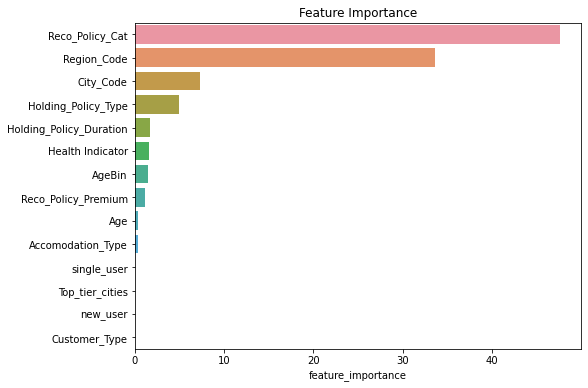

In [303]:
feature_importance = model3.get_feature_importance()
feature_importance_df = pd.DataFrame(
    data={'feature_importance': feature_importance},
    index=column_list
)
feature_importance_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance_df['feature_importance'], y=feature_importance_df.index)
plt.title('Feature Importance')
plt.show()


In [272]:
prediction=model.predict_proba(test.drop(['ID'], axis=1))[:,1]

In [275]:
prediction

array([0.07104221, 0.09976495, 0.44024003, ..., 0.01917527, 0.55878762,
       0.08735924])

In [276]:
submission = pd.DataFrame({'ID':test['ID'], 'Response':prediction})

In [277]:
submission.head()

,ID,Response
50882,50883,0.071042
50883,50884,0.099765
50884,50885,0.440240
50885,50886,0.103845
50886,50887,0.034382


In [278]:
submission.to_csv('submission2.csv', header=True, index=False)